In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score

In [2]:
model_1_data = pd.read_csv('model_1/model_1_data.csv')

In [3]:
model_1_data['score_diff'] = model_1_data['attack_score'] - model_1_data['defend_score']

In [5]:
model_1_data['score'] = ((model_1_data['score_1'] == 1) | (model_1_data['score_2'] == 1) | (model_1_data['score_3'] == 1)).astype(int)

In [20]:
model_1_data.score_1.value_counts()

score_1
0    4185
1    2633
Name: count, dtype: int64

In [7]:
features = ["score_diff", "SoF", "attacker_count", "defender_count"]
target = "score"

In [23]:
model_df = model_1_data[features+[target]]

In [9]:
model_df.isna().sum()

score_diff        0
SoF               0
attacker_count    0
defender_count    0
score             0
dtype: int64

In [10]:
model_df = model_df[model_df['SoF']<300]

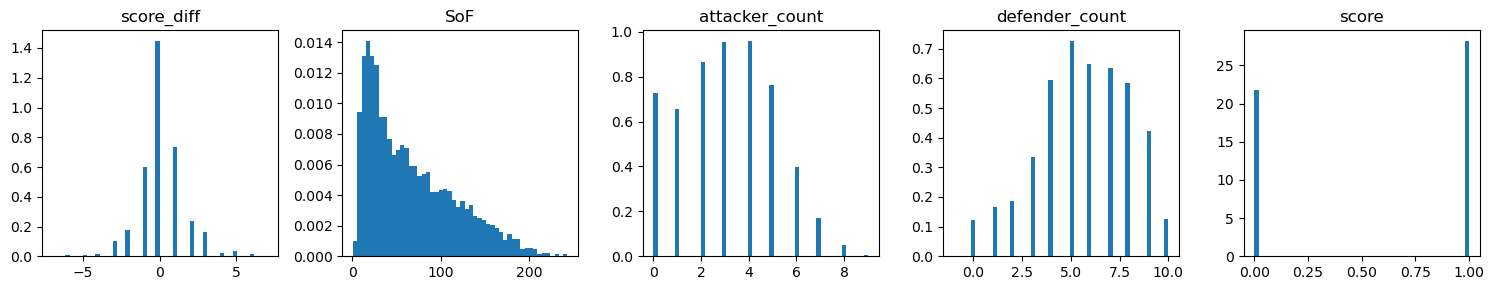

In [11]:
plt.figure(figsize=(18,3))

for i, col in enumerate(features+[target]):
    plt.subplot(1, 6, i+1)
    plt.hist(model_df[col], bins=50, density=True)
    plt.title(col)

plt.tight_layout()
plt.show()

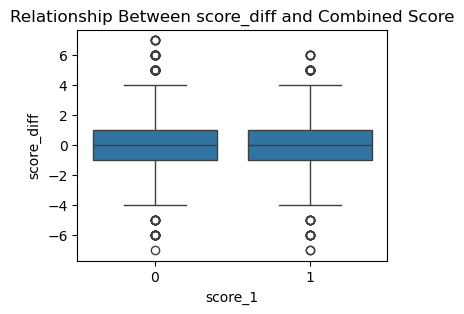

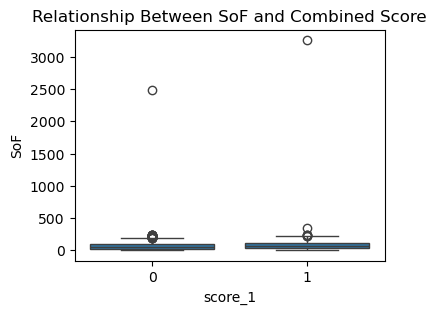

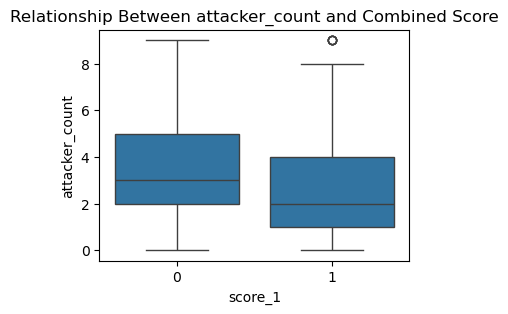

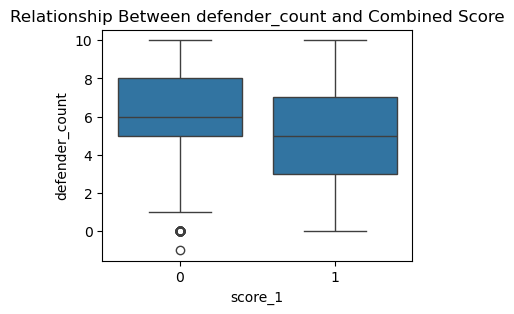

In [24]:
for feature in features:
    plt.figure(figsize=(4,3))
    sns.boxplot(x=model_df[target], y=model_df[feature])
    plt.title(f"Relationship Between {feature} and Combined Score")
    plt.xlabel(target)
    plt.ylabel(feature)
    plt.show()

In [40]:
model_df[target].value_counts()

combined_score
0.000000    2974
1.651225    1668
0.651225    1210
1.000000     963
Name: count, dtype: int64

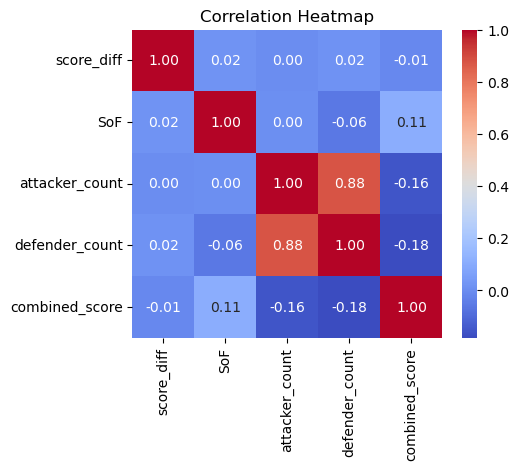

In [62]:
correlation_matrix = model_df[features + [target]].corr()
plt.figure(figsize=(5,4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [63]:
model_df["combined_score"] = model_df["combined_score"].astype("category")

In [21]:
target = 'score_1'

In [30]:
X = model_df[features]
y = model_df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [31]:
models = {
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 150],
            "max_depth": [None, 10, 20],
        },
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 150],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7],
        },
    },
    "LogisticRegression": {
        "model": LogisticRegression(random_state=42, max_iter=500),
        "params": {
            "C": [0.1, 1, 10],
            "penalty": ["l2"],
            "solver": ["liblinear", "lbfgs"],
        },
    },
    "KNeighbors": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"],
        },
    },
    "XGBoost": {
        "model": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"),
        "params": {
            "n_estimators": [50, 100, 150],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7],
        },
    },
}

# Perform GridSearchCV for each model
best_models = {}
for name, entry in models.items():
    print(f"Optimizing {name}...")
    grid = GridSearchCV(entry["model"], entry["params"], cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"Best params for {name}: {grid.best_params_}")
    print(f"Best cross-validated accuracy for {name}: {grid.best_score_:.4f}\n")

# Compare performance on the test set
print("Performance Comparison:")
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")

Optimizing RandomForest...
Best params for RandomForest: {'max_depth': 20, 'n_estimators': 100}
Best cross-validated accuracy for RandomForest: 0.6511

Optimizing GradientBoosting...
Best params for GradientBoosting: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Best cross-validated accuracy for GradientBoosting: 0.6388

Optimizing LogisticRegression...
Best params for LogisticRegression: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validated accuracy for LogisticRegression: 0.6249

Optimizing KNeighbors...
Best params for KNeighbors: {'n_neighbors': 3, 'weights': 'distance'}
Best cross-validated accuracy for KNeighbors: 0.6585

Optimizing XGBoost...
Best params for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Best cross-validated accuracy for XGBoost: 0.6407

Performance Comparison:
Model: RandomForest
Accuracy: 0.5924
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.63  

C:\Users\lorih\anaconda3\envs\asi12\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:57:02] WARNING: D:\bld\xgboost-split_1733179535861\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [82]:
results_df

,Best Params,MSE,R2
Lasso,{'alpha': 0.001},0.415427,0.030002
Ridge,{'alpha': 10},0.415453,0.02994
Linear Regression,{},0.415475,0.029889
Random Forest,"{'max_depth': 10, 'n_estimators': 200}",0.426345,0.004509
Gradient Boosting,"{'learning_rate': 0.1, 'n_estimators': 50}",0.416057,0.028531
